<a href="https://colab.research.google.com/github/isaacbilsel/GNN-Proteins/blob/isaac/TRIALPYT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install all PyTorch Geometric dependencies (CPU version)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
!pip install -q torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.2 MB/s eta 0:00:00


In [2]:
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

# Load train, val, and test sets
train_dataset = PPI(root='data/PPI', split='train')
val_dataset = PPI(root='data/PPI', split='val')
test_dataset = PPI(root='data/PPI', split='test')

# Wrap in data loaders for batch training
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of nodes in first graph: {train_dataset[0].num_nodes}")
print(f"Feature shape: {train_dataset[0].x.shape}")
print(f"Labels shape: {train_dataset[0].y.shape}")


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
Extracting data/PPI/ppi.zip
Processing...
/usr/local/lib/python3.11/dist-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

 

Number of training graphs: 20
Number of nodes in first graph: 1767
Feature shape: torch.Size([1767, 50])
Labels shape: torch.Size([1767, 121])


Done!


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv
from sklearn.metrics import f1_score

# Load datasets
train_dataset = PPI(root='data/PPI', split='train')
val_dataset = PPI(root='data/PPI', split='val')
test_dataset = PPI(root='data/PPI', split='test')

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

# GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_feats)
        self.conv2 = SAGEConv(hidden_feats, out_feats)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return torch.sigmoid(x)

# Init model, optimizer, loss
in_feats = train_dataset.num_node_features
out_feats = train_dataset.num_classes
hidden_feats = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphSAGE(in_feats, hidden_feats, out_feats).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.BCELoss()

# Evaluation helper
def evaluate(loader):
    model.eval()
    total_f1 = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            preds = (out > 0.5).float()
            f1 = f1_score(batch.y.cpu().numpy(), preds.cpu().numpy(), average='micro')
            total_f1 += f1
    return total_f1 / len(loader)

# Training function with validation
def train_model(model, train_loader, val_loader, epochs=100):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)
            loss = loss_fn(out, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation F1
        val_f1 = evaluate(val_loader)
        print(f"Epoch {epoch}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val F1: {val_f1:.4f}")

# Train
train_model(model, train_loader, val_loader)

# Final test evaluation
test_f1 = evaluate(test_loader)
print(f"🎯 Final Test Micro-F1: {test_f1:.4f}")


Epoch 1/100, Loss: 0.5838, Val F1: 0.3853
Epoch 2/100, Loss: 0.5446, Val F1: 0.4403
Epoch 3/100, Loss: 0.5311, Val F1: 0.4347
Epoch 4/100, Loss: 0.5231, Val F1: 0.4590
Epoch 5/100, Loss: 0.5172, Val F1: 0.4852
Epoch 6/100, Loss: 0.5153, Val F1: 0.4853
Epoch 7/100, Loss: 0.5115, Val F1: 0.4783
Epoch 8/100, Loss: 0.5097, Val F1: 0.4704
Epoch 9/100, Loss: 0.5084, Val F1: 0.4474
Epoch 10/100, Loss: 0.5087, Val F1: 0.5024
Epoch 11/100, Loss: 0.5081, Val F1: 0.4754
Epoch 12/100, Loss: 0.5083, Val F1: 0.4200
Epoch 13/100, Loss: 0.5072, Val F1: 0.4893
Epoch 14/100, Loss: 0.5070, Val F1: 0.4902
Epoch 15/100, Loss: 0.5074, Val F1: 0.4600
Epoch 16/100, Loss: 0.5059, Val F1: 0.4722
Epoch 17/100, Loss: 0.5046, Val F1: 0.4840
Epoch 18/100, Loss: 0.5060, Val F1: 0.4765
Epoch 19/100, Loss: 0.5065, Val F1: 0.4659
Epoch 20/100, Loss: 0.5052, Val F1: 0.4865
Epoch 21/100, Loss: 0.5051, Val F1: 0.4589
Epoch 22/100, Loss: 0.5046, Val F1: 0.4915
Epoch 23/100, Loss: 0.5049, Val F1: 0.4877
Epoch 24/100, Loss: 

KeyboardInterrupt: 

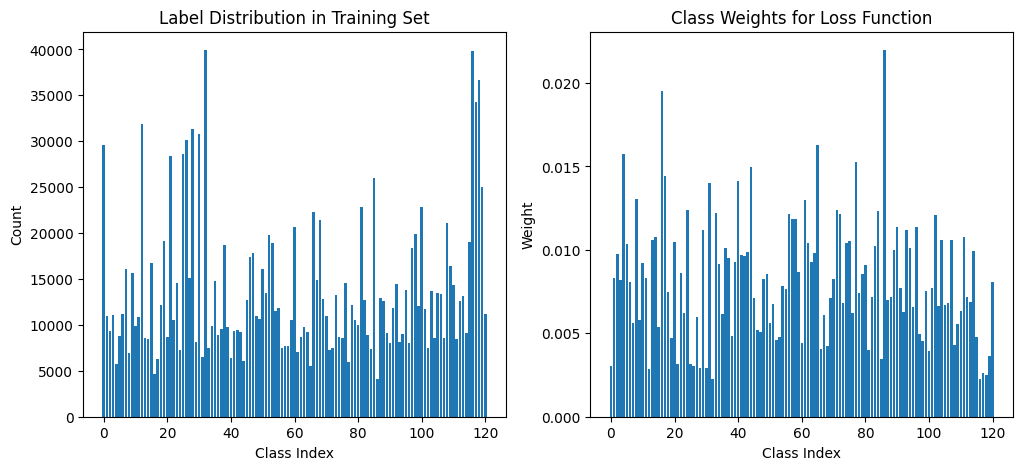

Epoch 1/100, Loss: 0.0053, Val F1: 0.4036
Epoch 2/100, Loss: 0.0054, Val F1: 0.3883
Epoch 3/100, Loss: 0.0055, Val F1: 0.4106
Epoch 4/100, Loss: 0.0056, Val F1: 0.3776
Epoch 5/100, Loss: 0.0056, Val F1: 0.4139
Epoch 6/100, Loss: 0.0056, Val F1: 0.3934
Epoch 7/100, Loss: 0.0056, Val F1: 0.3935
Epoch 8/100, Loss: 0.0056, Val F1: 0.3816
Epoch 9/100, Loss: 0.0056, Val F1: 0.3816
Epoch 10/100, Loss: 0.0056, Val F1: 0.3924
Epoch 11/100, Loss: 0.0056, Val F1: 0.3911
Epoch 12/100, Loss: 0.0056, Val F1: 0.3935
Epoch 13/100, Loss: 0.0056, Val F1: 0.3693
Epoch 14/100, Loss: 0.0056, Val F1: 0.3935
Epoch 15/100, Loss: 0.0056, Val F1: 0.3935
Epoch 16/100, Loss: 0.0056, Val F1: 0.3816
Epoch 17/100, Loss: 0.0056, Val F1: 0.4050
Epoch 18/100, Loss: 0.0056, Val F1: 0.4132
Epoch 19/100, Loss: 0.0056, Val F1: 0.3816
Epoch 20/100, Loss: 0.0056, Val F1: 0.3935
Epoch 21/100, Loss: 0.0056, Val F1: 0.4039
Epoch 22/100, Loss: 0.0056, Val F1: 0.3924
Epoch 23/100, Loss: 0.0056, Val F1: 0.3935
Epoch 24/100, Loss: 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv
from sklearn.metrics import f1_score
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load datasets
train_dataset = PPI(root='data/PPI', split='train')
val_dataset = PPI(root='data/PPI', split='val')
test_dataset = PPI(root='data/PPI', split='test')

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

# Compute class weights from training dataset
def compute_class_weights(train_dataset):
    label_sum = torch.zeros(train_dataset.num_classes)
    total_samples = 0
    for data in train_dataset:
        label_sum += data.y.sum(dim=0)
        total_samples += data.y.size(0)

    class_weights = total_samples / (train_dataset.num_classes * label_sum)
    class_weights = class_weights / class_weights.sum()  # Normalize
    return label_sum, class_weights.to(torch.float32)

label_distribution, class_weights = compute_class_weights(train_dataset)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)

# Plot label distribution and class weights
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].bar(range(len(label_distribution)), label_distribution.numpy())
axs[0].set_title("Label Distribution in Training Set")
axs[0].set_xlabel("Class Index")
axs[0].set_ylabel("Count")

axs[1].bar(range(len(class_weights)), class_weights.cpu().numpy())
axs[1].set_title("Class Weights for Loss Function")
axs[1].set_xlabel("Class Index")
axs[1].set_ylabel("Weight")

plt.show()

# GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_feats)
        self.conv2 = SAGEConv(hidden_feats, out_feats)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return torch.sigmoid(x)

# Init model, optimizer, loss
in_feats = train_dataset.num_node_features
out_feats = train_dataset.num_classes
hidden_feats = 256

model = GraphSAGE(in_feats, hidden_feats, out_feats).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def weighted_bce_loss(preds, targets, weights):
    loss = F.binary_cross_entropy(preds, targets, weight=weights)
    return loss

# Evaluation helper
def evaluate(loader):
    model.eval()
    total_f1 = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            preds = (out > 0.5).float()
            f1 = f1_score(batch.y.cpu().numpy(), preds.cpu().numpy(), average='micro')
            total_f1 += f1
    return total_f1 / len(loader)

# Training function with validation
def train_model(model, train_loader, val_loader, epochs=100):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)
            loss = weighted_bce_loss(out, batch.y, class_weights)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation F1
        val_f1 = evaluate(val_loader)
        print(f"Epoch {epoch}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val F1: {val_f1:.4f}")

# Train
train_model(model, train_loader, val_loader)

# Final test evaluation
test_f1 = evaluate(test_loader)
print(f"🎯 Final Test Micro-F1: {test_f1:.4f}")
